<a href="https://colab.research.google.com/github/dbtronics/COMP551-Miniproject-1/blob/main/KNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cProfile import label
from IPython.core.debugger import set_trace
import enum
import seaborn as sns

In [35]:
def task1():
    data3 = arff.loadarff('./sample_data/messidor_features.arff')
    data3 = pd.DataFrame(data3[0])
    col_names = ['qual_assess','pre_screen','MA_detection_.5','MA_detection_.6','MA_detection_.7','MA_detection_.8',
            'MA_detection_.9','MA_detection_1.0','exudate_detection_.3','exudate_detection_.4','exudate_detection_.5','exudate_detection_.6'
            ,'exudate_detection_.7','exudate_detection_.8','exudate_detection_.9','exudate_detection_1.0',
            'euc_dist','diam_opt_disc','AM/FM','class_label']
    data3.columns = col_names
    data3.class_label = data3.class_label.apply(lambda x: pd.to_numeric(str(x)[2]))
    data3 = data3.replace({'?' : np.nan}).dropna()
    print("Correlation matrix for Diabetes Dataset")
    plt.figure(figsize = (15,12))
    corr = data3.corr()
    sns.heatmap(corr, annot = True)
    plt.savefig("diabetes_corr.png",dpi=1200,transparent=True,bbox_inches = 'tight')
    
    # print(df.corr())
    print(data3)
    # basic statistics df
    print(data3.describe(include='all'), end="\n")
    # Document messidor features.arff above
    # Document hepatitis below
    df2 = pd.read_csv('./sample_data/hepatitis1.csv', 
    names=["class", "age", "sex", "steroid", "antivirals", 
    "fatigue", "malaise", "anorexia", "liver_big", "liver_firm", 
    "spleen_palpable", "spiders", "ascites", "varices", "bilirubin", 
    "alk_phosphate", "sgot", "albumin", "protime", "histology"])
    df2 = df2.replace({'?': np.nan}).dropna()
    af = df2.select_dtypes(include="object")
    dic = {}
    for i in af:
      df2[i] = df2[i].astype(float, errors = "raise")
    df2.astype(dic).dtypes
    plt.figure(figsize = (15,12))
    corr = df2.corr()
    print("Correlation matrix for Hepatitis Dataset")
    sns.heatmap(corr, annot = True)
    plt.savefig("hepatitis_corr.png",dpi=1200,transparent=True,bbox_inches = 'tight')
    # print(df2.corr())
    print(df2)
    # basic statistics df2
    print(df2.describe(include='all'))

    # data3 = data3.to_numpy()
    # df2 = df2.to_numpy()
    # print(df[:, 18:]) # taking values that are besides 1 and 0
    # print(df2[:, 16:]) # taking values that are besides 1 and 0
    return data3, df2 # messidor and hep data respectively

In [29]:
# Used for picking up features for decision boundary
class DIABETES (enum.IntEnum):
  QUALITY = 0
  PRE_SCREENING = 1
  MA_DETECTION_5 = 2
  MA_DETECTION_6 = 3
  MA_DETECTION_7 = 4
  MA_DETECTION_8 = 5
  MA_DETECTION_9 = 6
  MA_DETECTION_10 = 7
  EXUDATES_3 = 8
  EXUDATES_4 = 9
  EXUDATES_5 = 10
  EXUDATES_6 = 11
  EXUDATES_7 = 12
  EXUDATES_8 = 13
  EXUDATES_9 = 14
  EXUDATES_10 = 15
  DISTANCE = 16
  DIAMETER = 17
  AM_FM_CLASSIFICATION = 18
  CLASS = 19

class HEPATITIS (enum.IntEnum):
  CLASS = 0
  AGE = 1
  SEX = 2
  STEROID = 3
  ANTIVIRALS = 4
  FATIGUE = 5
  MALAISE = 6
  ANOREXIA = 7
  LIVER_BIG = 8
  LIVER_FIRM = 9
  SPLEEN_PALPABLE = 10
  SPIDERS = 11
  ASCITES = 12
  VARICES = 13
  BILIRUBIN = 14
  ALK_PHOSPHATE = 15
  SGOT = 16
  ALBUMIN = 17
  PROTIME = 18
  HISTOLOGY = 19

In [5]:
#it is important to set the seed for reproducibility as it initializes the random number generator
np.random.seed(1234)

#define the metric we will use to measure similarity
#if the input shapes are [1,N1,F] and [N2,1,F] then output shape is [N2,N1]
#as numpy supports broadcasting with arithmetic operations
#for more on numpy broadcasting refer to: https://numpy.org/doc/stable/user/basics.broadcasting.html   
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        #calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        #y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        #simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

    def evaluate_acc(self, y_test, y_pred):
        # correct_pred = y_test == y_pred # gets all the index of correct prediction
        # accuracy = np.sum(y_test == y_pred) # in percentage
        # accuracy /= y_test.shape[0] * 100
        correct_pred, accuracy = 0, 0
        for i in range(y_pred.shape[0]): correct_pred += y_test[i] == y_pred[i]
        accuracy = correct_pred/(y_pred.shape[0]) * 100
        return accuracy

In [38]:
def task2(k, x_train, y_train, x_test, distance):
    # import KNN as kmodel
    model_knn = KNN(K=k, dist_fn = distance)
    y_prob_knn, knn = model_knn.fit(x_train, y_train).predict(x_test)
    y_pred = np.argmax(y_prob_knn, axis = -1)
    accuracy_knn = model_knn.evaluate_acc(y_train, y_pred)
    return accuracy_knn

In [7]:
def decision_boundary(x, x_train, y_train):
    #we can make the grid finer by increasing the number of samples from 200 to higher value
    x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
    x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

    #to features values as a mesh  
    x0, x1 = np.meshgrid(x0v, x1v)
    x_all = np.vstack((x0.ravel(),x1.ravel())).T

    for k in range(1,4):
        # import KNN as kmodel
        model = KNN(K=k)

        C = np.max(y_train) + 1
        # C = 3
        y_train_prob = np.zeros((y_train.shape[0], C))
        y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

        #to get class probability of all the points in the 2D grid
        y_prob_all, _ = model.fit(x_train, y_train).predict(x_all)

        y_pred_all = np.zeros_like(y_prob_all)
        y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1
        # print(np.argmax(y_train_prob, axis = 1)-1)
        # print("\n")
        # print(np.argmax(y_pred_all, axis = 1)-1)
        plt.scatter(x_train[:,0], x_train[:,1], c=np.argmax(y_train_prob, axis = 1), marker='o', alpha=1)
        plt.scatter(x_all[:,0], x_all[:,1], c=np.argmax(y_pred_all, axis = 1), marker='.', alpha=0.01)
        plt.show()

Task 1 of extracting data and presenting a correlation matrix for decision boundary for Task 3

Correlation matrix for Diabetes Dataset
      qual_assess  pre_screen  ...  AM/FM  class_label
0             1.0         1.0  ...    1.0            0
1             1.0         1.0  ...    0.0            0
2             1.0         1.0  ...    0.0            1
3             1.0         1.0  ...    0.0            0
4             1.0         1.0  ...    0.0            1
...           ...         ...  ...    ...          ...
1146          1.0         1.0  ...    0.0            0
1147          1.0         1.0  ...    0.0            0
1148          1.0         0.0  ...    0.0            0
1149          1.0         1.0  ...    1.0            1
1150          1.0         1.0  ...    0.0            0

[1151 rows x 20 columns]
       qual_assess   pre_screen  ...        AM/FM  class_label
count  1151.000000  1151.000000  ...  1151.000000  1151.000000
mean      0.996525     0.918332  ...     0.336229     0.530843
std       0.058874     0.273977  ...     0.472624     0.499265
min       0.000000    

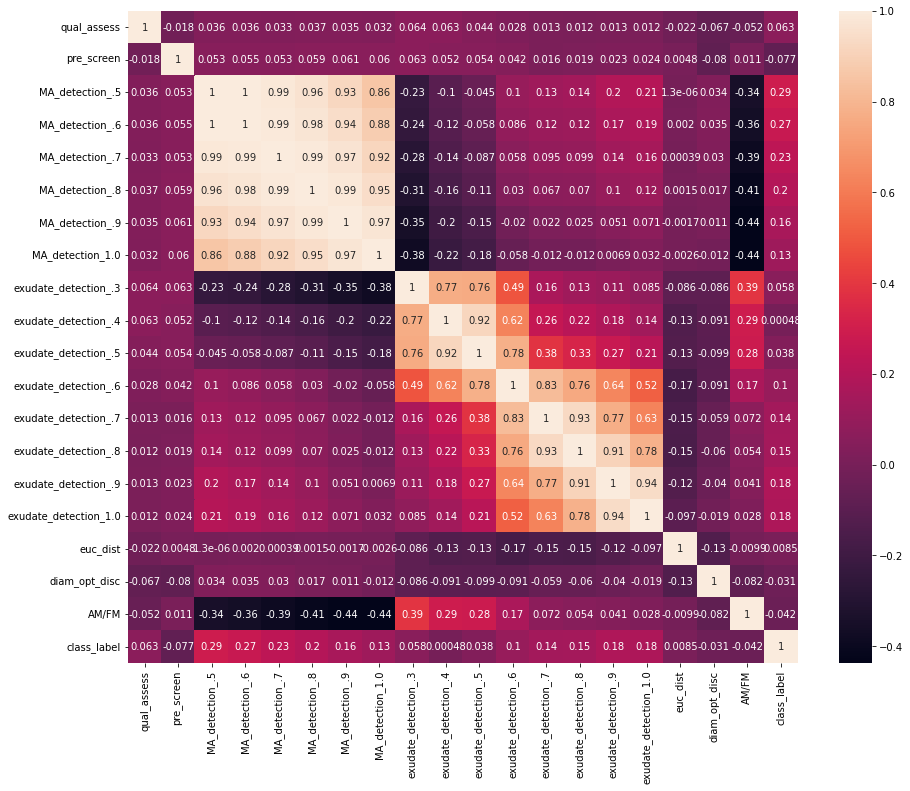

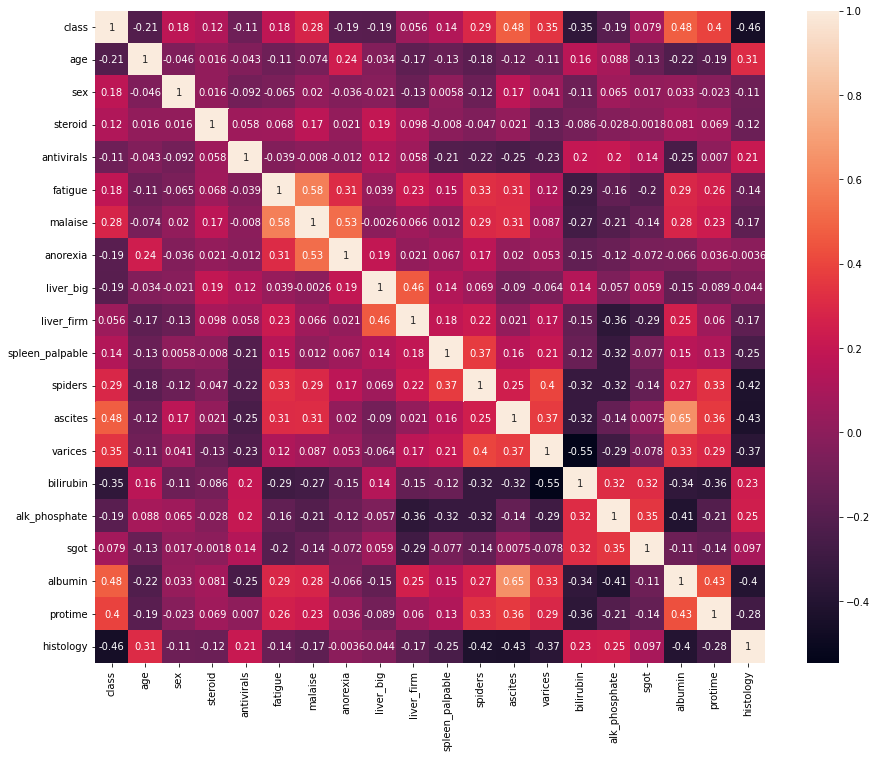

In [41]:
mess_data, hep_data = task1()

#parameter adjustment for corr column
messF1 = DIABETES.MA_DETECTION_5
messF2 = DIABETES.MA_DETECTION_6
hepF1 = HEPATITIS.ASCITES
hepF2 = HEPATITIS.ALBUMIN

# Shows corr coef for these specific features. Chose the data which had varrying values except binary values
print("Choosing Diabetes features: MA Detection 5 and MA Detection 6 because correlation number is : ", end="")
print(np.corrcoef(mess_data)[messF1, messF2])
print("\nChossing Hepatitis features: Ascetine and Albumin becaues correlation number is : ", end="")
print(np.corrcoef(hep_data)[hepF1, hepF2], end="\n") # error with corr. It shows 0.98 but in reality it is 0.65 RESOLVE THIS!!

Task 2 of showing KNN model and different data accuracy to training and test dataset

In [42]:
#convert to numpy for easy matrix manipulation rather than dictionary handling
mess_data = mess_data.to_numpy()
hep_data = hep_data.to_numpy()

# parameter adjustments
k_range = 11
train_portion = 8/10 # meaning 80% will be train dataset from total data

n_mess_train, n_hep_train = int(mess_data.shape[0] * train_portion), int(hep_data.shape[0] * train_portion)

# train data set for messidore
mess_x_train = mess_data[:n_mess_train, [messF1, messF2]] # All columns except last one
# mess_y_train = mess_data[:n_mess_train, -1].reshape(n_mess_train, 1) # only get last column i.e. class
mess_y_train = mess_data[:n_mess_train, -1]
mess_y_train = mess_y_train.astype(np.int32)
# test data set for messidore
mess_x_test = mess_data[n_mess_train:, [messF1, messF2]]
# mess_y_test = mess_data[n_mess_train:, -1].reshape(mess_data.shape[0] - n_mess_train, 1)
mess_y_test = mess_data[n_mess_train:, -1]
mess_y_test = mess_y_test.astype(np.int32)

#train data set for hepatitis
# hep_x_train = hep_data[:n_hep_train, 1:1+num_features]
hep_x_train = hep_data[:n_hep_train, [hepF1, hepF2]]
# hep_y_train = hep_data[:n_hep_train, 0].reshape(n_hep_train, 1)
hep_y_train = hep_data[:n_hep_train, 0]
hep_y_train = hep_y_train.astype(np.int32)
#test data set for hepatitis
# hep_x_test = hep_data[n_hep_train:, 1:1+num_features]
hep_x_test = hep_data[n_hep_train:, [hepF1, hepF2]]
# hep_y_test = hep_data[n_hep_train:, 0].reshape(hep_data.shape[0] - n_hep_train, 1)
hep_y_test = hep_data[n_hep_train:, 0]
hep_y_test = hep_y_test.astype(np.int32)

## We have test and train for both
## Let's work from here
print("Different accuracy for KNN on both dataset")
for i in range(1, k_range):
  print("K = ", i)
  print("Euclidean Distance:\t Messidore Accuracy with test dataset: ",
        task2(i, mess_x_train, mess_y_train, mess_x_test, euclidean), end="")
  print("\t\tHepatitis Accuracy with test dataset: ",
        task2(i, hep_x_train, hep_y_train, hep_x_test, euclidean),end="\n")
  print("Euclidean Distance:\t Messidore Accuracy with training dataset: ",
        task2(i, mess_x_train, mess_y_train, mess_x_train, euclidean), end="")
  print("\t\tHepatitis Accuracy with training dataset: ",
        task2(i, hep_x_train, hep_y_train, hep_x_train, euclidean),end="\n")
  print("Mahattan Distance:\t Messidore Accuracy with test dataset: ",
        task2(i, mess_x_train, mess_y_train, mess_x_test, manhattan), end="")
  print("\t\tHepatitis Accuracy with test dataset: ",
        task2(i, hep_x_train, hep_y_train, hep_x_test, manhattan),end="\n")
  print("Mahattan Distance:\t Messidore Accuracy with training data: ",
        task2(i, mess_x_train, mess_y_train, mess_x_train, manhattan), end="")
  print("\t\tHepatitis Accuracy with training data: ",
        task2(i, hep_x_train, hep_y_train, hep_x_train, manhattan),end="\n\n")

Different accuracy for KNN on both dataset
K =  1
Euclidean Distance:	 Messidore Accuracy with test dataset:  48.484848484848484		Hepatitis Accuracy with test dataset:  68.75
Euclidean Distance:	 Messidore Accuracy with training dataset:  75.10869565217392		Hepatitis Accuracy with training dataset:  93.75
Mahattan Distance:	 Messidore Accuracy with test dataset:  49.35064935064935		Hepatitis Accuracy with test dataset:  68.75
Mahattan Distance:	 Messidore Accuracy with training data:  74.56521739130434		Hepatitis Accuracy with training data:  93.75

K =  2
Euclidean Distance:	 Messidore Accuracy with test dataset:  48.917748917748916		Hepatitis Accuracy with test dataset:  50.0
Euclidean Distance:	 Messidore Accuracy with training dataset:  73.47826086956522		Hepatitis Accuracy with training dataset:  81.25
Mahattan Distance:	 Messidore Accuracy with test dataset:  48.05194805194805		Hepatitis Accuracy with test dataset:  50.0
Mahattan Distance:	 Messidore Accuracy with training data: 

Task 3 of showing different distance affect [DONE ON TASK 2] and display decision boundary

Decision Boundary for DIABETES dataset with MA DETECTION 5 and MA DETECTION 6 features


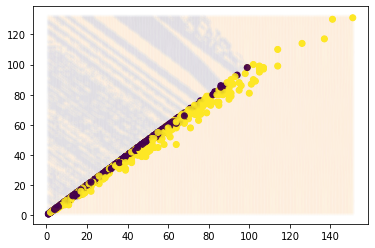

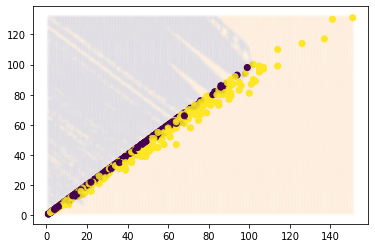

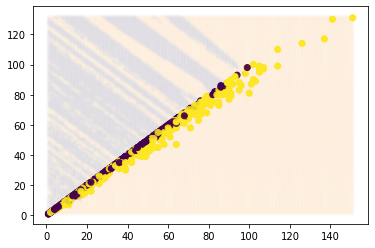


Decision Boundary for HEPATITIS dataset with ASCITES and ALBUMIN features


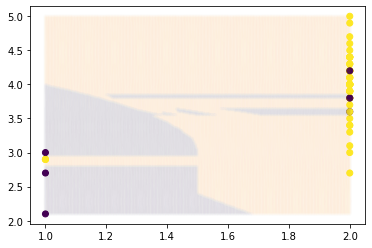

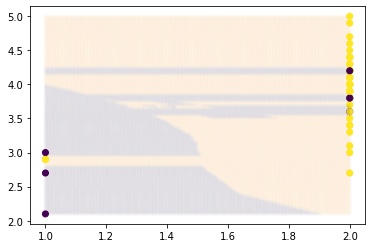

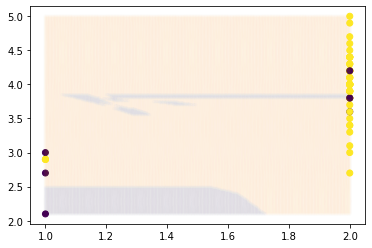

In [45]:
print("Decision Boundary for DIABETES dataset with MA DETECTION 5 and MA DETECTION 6 features")
decision_boundary(mess_data[:, [messF1, messF2]], mess_x_train, mess_y_train)
print("\nDecision Boundary for HEPATITIS dataset with ASCITES and ALBUMIN features")
decision_boundary(hep_data[:, [hepF1, hepF2]], hep_x_train, hep_y_train)